# Reject Shop - Can we predict the CLV over the next 3 months?

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import arange

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# I will use these models as well


# 1. Load Data

In [3]:
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail')

In [4]:
df.shape

(541909, 8)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Data Clean-Up

#### - Negative Quantity

In [6]:
df.loc[df['Quantity'] <= 0].shape

(10624, 8)

In [7]:
df.shape

(541909, 8)

In [8]:
df = df.loc[df['Quantity'] > 0]

In [9]:
df.shape

(531285, 8)

#### - Missing CustomerID

In [10]:
pd.isnull(df['CustomerID']).sum()

133361

In [11]:
df.shape

(531285, 8)

In [12]:
df = df[pd.notnull(df['CustomerID'])]

In [13]:
df.shape

(397924, 8)

In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### - Excluding Incomplete Month

In [15]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [16]:
df.loc[df['InvoiceDate'] >= '2011-12-01'].shape

(17304, 8)

In [17]:
df.shape

(397924, 8)

In [18]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [19]:
df.shape

(380620, 8)

#### - Total Sales

In [20]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [21]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### - Per Order Data

In [22]:
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum,
    'InvoiceDate': max
})

In [23]:
orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

# 3. Data Analysis

In [24]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [25]:
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

In [26]:
summary_df

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000     1   
12347.0       382.52   1294.32   4085.18    680.863333     6   
12348.0       227.44    892.80   1797.24    449.310000     4   
12349.0      1757.55   1757.55   1757.55   1757.550000     1   
12350.0       334.40    334.40    334.40    334.400000     1   
...              ...       ...       ...           ...   ...   
18280.0       180.60    180.60    180.60    180.600000     1   
18281.0        80.82     80.82     80.82     80.820000     1   
18282.0       100.21    100.21    100.21    100.210000     1   
18283.0         1.95    313.65   1886.88    125.792000    15   
18287.0        70.68   1001.32   1837.28    612.426667     3   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   
...                        ...                 ...               ...   
18280.0    2011-03-07 09:52:00 2011-03-07 09:52:00                 0   
18281.0    2011-06-12 10:53:00 2011-06-12 10:53:00                 0   
18282.0    2011-08-05 13:35:00 2011-08-05 13:35:00                 0   
18283.0    2011-01-06 14:14:00 2011-11-30 12:59:00               327   
18287.0    2011-05-22 10:39:00 2011-10-28 09:29:00               158   

                               
           purchase_frequency  
CustomerID                     
12346.0              0.000000  
12347.0             54.500000  
12348.0             70.500000  
12349.0              0.000000  
12350.0              0.000000  
...                       ...  
18280.0              0.000000  
18281.0              0.000000  
18282.0              0.000000  
18283.0             21.800000  
18287.0             52.666667  

[4298 rows x 9 columns]

In [27]:
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [28]:
summary_df

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000
12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000
...,...,...,...,...,...,...,...,...,...
18280.0,180.60,180.60,180.60,180.600000,1,2011-03-07 09:52:00,2011-03-07 09:52:00,0,0.000000
18281.0,80.82,80.82,80.82,80.820000,1,2011-06-12 10:53:00,2011-06-12 10:53:00,0,0.000000
18282.0,100.21,100.21,100.21,100.210000,1,2011-08-05 13:35:00,2011-08-05 13:35:00,0,0.000000


In [29]:
summary_df.shape

(4298, 9)

In [30]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

In [31]:
summary_df.shape

(2692, 9)

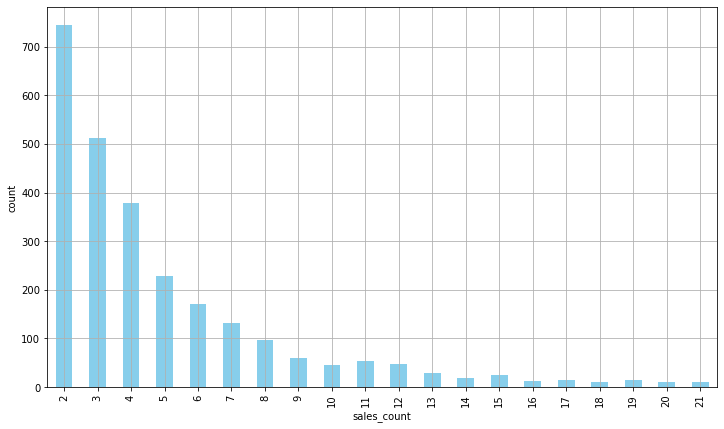

In [32]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', 
    color='skyblue',
    figsize=(12,7), 
    grid=True
)

ax.set_ylabel('count')

plt.show()

In [33]:
summary_df['sales_count'].describe()

count    2692.000000
mean        5.971025
std         8.878128
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max       201.000000
Name: sales_count, dtype: float64

In [34]:
summary_df['sales_avg'].describe()

count     2692.000000
mean       391.458687
std        465.584404
min          3.450000
25%        197.661000
50%        306.043333
75%        444.524000
max      14844.766667
Name: sales_avg, dtype: float64

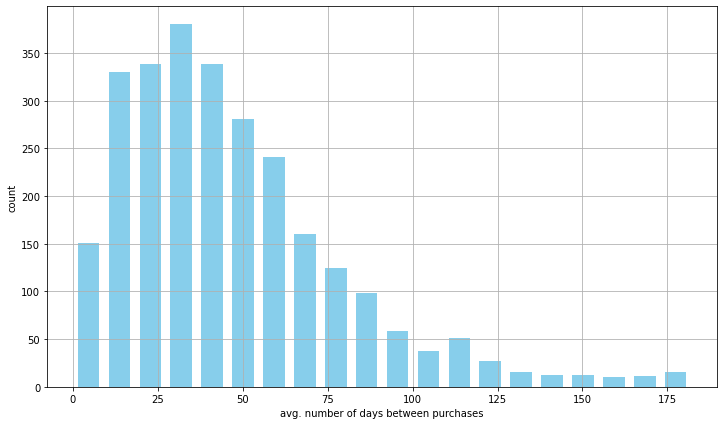

In [35]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')

plt.show()

In [36]:
summary_df['invoicedate_purchase_frequency'].describe()

count    2692.000000
mean       46.999022
std        32.395004
min         0.029412
25%        23.500000
50%        40.500000
75%        62.333333
max       182.000000
Name: invoicedate_purchase_frequency, dtype: float64

In [37]:
summary_df['invoicedate_purchase_duration'].describe()

count    2692.000000
mean      199.720282
std       107.816559
min         1.000000
25%       107.000000
50%       209.000000
75%       296.000000
max       364.000000
Name: invoicedate_purchase_duration, dtype: float64

# 4. Predicting 3-Month CLV

## 4.1. Data Preparation

In [38]:
clv_freq = '3M'

In [39]:
data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

In [40]:
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]

In [41]:
data_df = data_df.reset_index()

In [42]:
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1
5,12347.0,2011-12-31,1294.32,1294.320,1
6,12348.0,2010-12-31,892.80,892.800,1
7,12348.0,2011-03-31,227.44,227.440,1
8,12348.0,2011-06-30,367.00,367.000,1
9,12348.0,2011-09-30,310.00,310.000,1


In [43]:
date_month_map = {
    str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}

In [44]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])

In [45]:
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [46]:
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1,M_1
6,12348.0,2010-12-31,892.80,892.800,1,M_5
7,12348.0,2011-03-31,227.44,227.440,1,M_4
8,12348.0,2011-06-30,367.00,367.000,1,M_3
9,12348.0,2011-09-30,310.00,310.000,1,M_2


### Building Sample Set

This is our set to build LTV

In [47]:
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'], 
    columns='M', 
    index='CustomerID'
)

In [48]:
features_df.columns = ['_'.join(col) for col in features_df.columns]

In [49]:
features_df.shape

(3616, 12)

In [50]:
features_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.25,NaN,312.362,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN
12353.0,NaN,89.000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,89.00,NaN,NaN
12354.0,NaN,1079.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1079.40,NaN,NaN
12355.0,NaN,459.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,459.40,NaN,NaN
12356.0,NaN,481.460,2271.620,NaN,NaN,1.0,1.0,NaN,NaN,481.46,2271.62,NaN


In [51]:
features_df = features_df.fillna(0)

In [52]:
features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00


In [53]:
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

In [54]:
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]

In [55]:
response_df.shape

(2407, 2)

In [56]:
response_df.head(20)

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
25,12359.0,2876.85
28,12360.0,1043.78
33,12362.0,2119.85
37,12364.0,299.06
41,12370.0,739.28


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff9c62e7e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff9a9147190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff9c62e7df0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff9c33f9d30>],
 'fliers': [],
 'means': []}

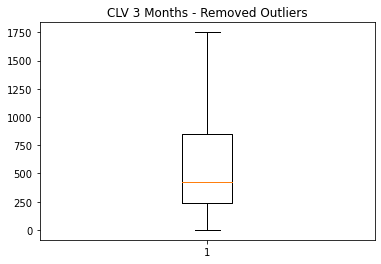

In [128]:


data = response_df['CLV_3M']
fig1, ax1 = plt.subplots()
ax1.set_title('CLV 3 Months - Removed Outliers')
ax1.boxplot(data, showfliers=False)


In [139]:
# plt.scatter(x = response_df['CLV_3M'], y = response_df['CustomerID'])
# plt.xlabel('CLV_3M')
# plt.ylabel('ID')

In [58]:
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

In [59]:
sample_set_df.shape

(3616, 14)

In [60]:
sample_set_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,NaN
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,NaN
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,NaN
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
NaN,0.00,89.000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,89.00,0.00,0.00,12353.0,NaN
NaN,0.00,1079.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,1079.40,0.00,0.00,12354.0,NaN
NaN,0.00,459.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,459.40,0.00,0.00,12355.0,NaN
20.0,0.00,481.460,2271.620,0.00,0.0,1.0,1.0,0.0,0.00,481.46,2271.62,0.00,12356.0,58.35
NaN,484.86,0.000,0.000,0.00,1.0,0.0,0.0,0.0,484.86,0.00,0.00,0.00,12358.0,NaN


In [61]:
sample_set_df = sample_set_df.fillna(0)

In [62]:
sample_set_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
NaN,0.00,89.000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,89.00,0.00,0.00,12353.0,0.00
NaN,0.00,1079.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,1079.40,0.00,0.00,12354.0,0.00
NaN,0.00,459.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,459.40,0.00,0.00,12355.0,0.00
20.0,0.00,481.460,2271.620,0.00,0.0,1.0,1.0,0.0,0.00,481.46,2271.62,0.00,12356.0,58.35
NaN,484.86,0.000,0.000,0.00,1.0,0.0,0.0,0.0,484.86,0.00,0.00,0.00,12358.0,0.00


In [63]:
sample_set_df['CLV_'+clv_freq].describe()

count     3616.000000
mean       511.558520
std       2371.743293
min          0.000000
25%          0.000000
50%          0.000000
75%        458.662500
max      68012.350000
Name: CLV_3M, dtype: float64

In [64]:
sample_set_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
NaN,0.00,89.000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,89.00,0.00,0.00,12353.0,0.00
NaN,0.00,1079.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,1079.40,0.00,0.00,12354.0,0.00
NaN,0.00,459.400,0.000,0.00,0.0,1.0,0.0,0.0,0.00,459.40,0.00,0.00,12355.0,0.00
20.0,0.00,481.460,2271.620,0.00,0.0,1.0,1.0,0.0,0.00,481.46,2271.62,0.00,12356.0,58.35
NaN,484.86,0.000,0.000,0.00,1.0,0.0,0.0,0.0,484.86,0.00,0.00,0.00,12358.0,0.00


## 4.2. Models

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [67]:
X = sample_set_df[all_features]
y = sample_set_df[target_var]

In [68]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=38)


### Linear Regression

#### Model No. 1 Linear Regression Model

In [70]:
reg_fit = LinearRegression()

In [71]:
reg_fit.fit(X_train, y_train)

LinearRegression()

In [72]:
reg_fit.score(X_train,y_train)

0.7322569617846946

In [73]:
reg_fit.score(X_test,y_test)

print('R2 value with training dataset',reg_fit.score(X_train,y_train))
print('R2 value with testing dataset',reg_fit.score(X_test,y_test))

R2 value with training dataset 0.7322569617846946
R2 value with testing dataset 0.6779858219758952


In [74]:
reg_fit.intercept_

93.28627179505497

In [75]:
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['feature', 'coef']

coef

,feature,coef
0,sales_avg_M_2,0.261605
1,sales_avg_M_3,-0.513462
2,sales_avg_M_4,-0.184639
3,sales_avg_M_5,-0.417275
4,sales_count_M_2,98.185475
5,sales_count_M_3,0.696103
6,sales_count_M_4,-116.527379
7,sales_count_M_5,-45.295534
8,sales_sum_M_2,0.220992
9,sales_sum_M_3,0.361732


In [76]:
test_pred = reg_fit.predict(X_test)
train_pred = reg_fit.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 370.94598343999655
MSE: 581459.4476048306
RMSE: 762.5348828773872
R2 Square 0.6779858219758952
__________________________________
Train set evaluation:
_____________________________________
MAE: 426.5559156141141
MSE: 1760939.7728434077
RMSE: 1327.0040590907804
R2 Square 0.7322569617846946
__________________________________


#### Model No.2  Lasso Regression

In [77]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 345.46932212610716
MSE: 591864.7376738169
RMSE: 769.3274580266955
R2 Square 0.6722233376917905
__________________________________
Train set evaluation:
_____________________________________
MAE: 405.8456810669286
MSE: 1828327.0274069065
RMSE: 1352.1564359965553
R2 Square 0.7220110302928492
__________________________________


#### Model No.3 —  Random Forest Regressor

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 365.2000446148108
MSE: 802606.1394088157
RMSE: 895.8828826408146
R2 Square 0.5555140477578462
__________________________________
Train set evaluation:
_____________________________________
MAE: 161.05069740750196
MSE: 312081.0137140539
RMSE: 558.6421159508598
R2 Square 0.9525494738265852
__________________________________


## 5. Model Summary

In [79]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,370.945983,581459.447605,762.534883,0.677986,0.371450
1,Lasso Regression,345.469322,591864.737674,769.327458,0.672223,0.372052
2,Random Forest Regressor,365.200045,802606.139409,895.882883,0.555514,0.000000


<AxesSubplot:ylabel='Model'>

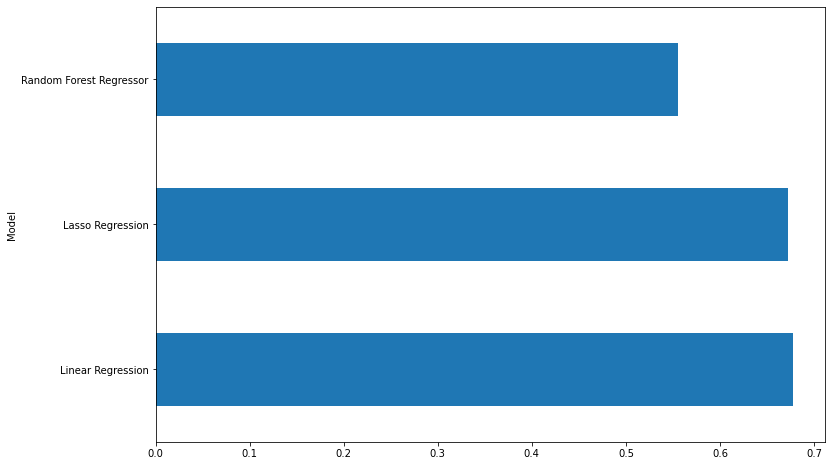

In [80]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

## 6. Plotting a 3 Month CLV Prediction

These diagrams show the prediction of your your CLV mapped to future values.

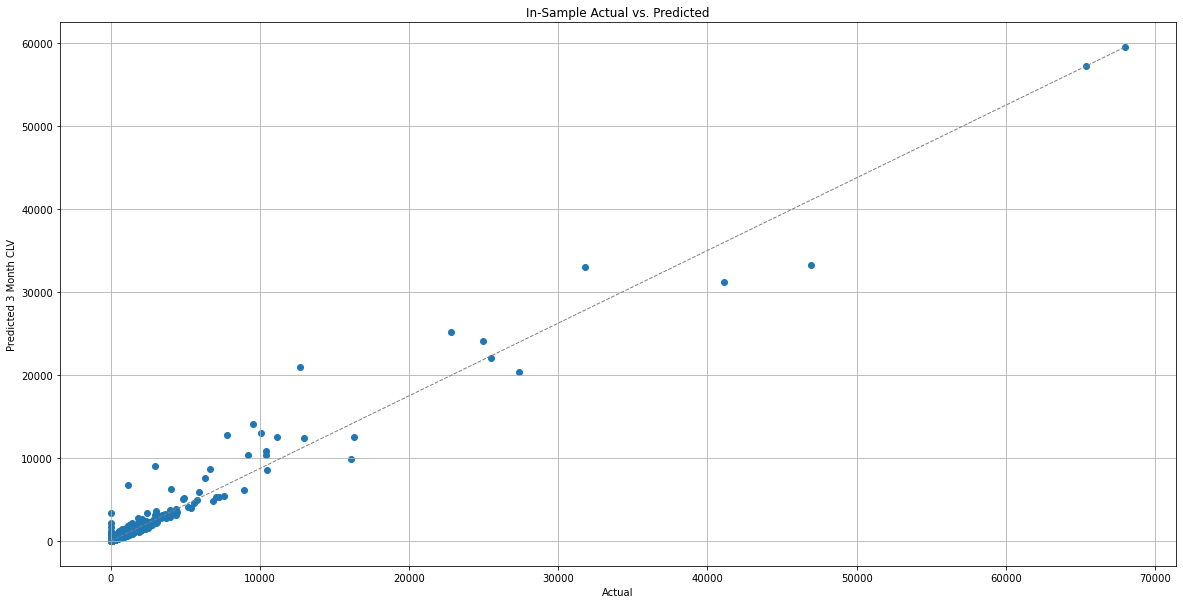

In [109]:
plt.figure(figsize=(20,10))

plt.scatter(y_train, train_pred)
plt.plot([0, max(y_train)], [0, max(train_pred)], color='gray', lw=1, linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted 3 Month CLV')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()
plt.show()

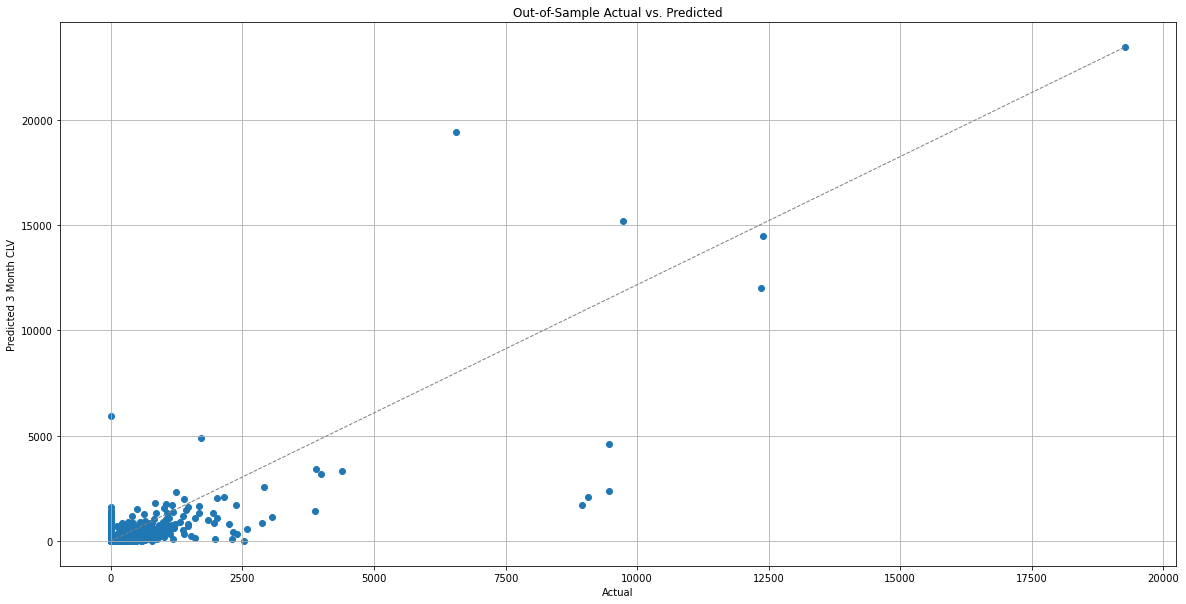

In [108]:
plt.figure(figsize=(20,10))

plt.scatter(y_test, test_pred)
plt.plot([0, max(y_test)], [0, max(test_pred)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual')
plt.ylabel('Predicted 3 Month CLV')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()

In [138]:
# plt.figure(figsize=(20,10))

# plt.scatter(y_train, train_pred)
# plt.plot([0, max(y_train)], [0, max(train_pred)], color='gray', lw=1, linestyle='--')
# plt.xlabel('Actual')
# plt.ylabel('Predicted 3 Month CLV')
# plt.title('In-Sample Actual vs. Predicted')
# plt.grid()
# plt.show()


# data = [0, max(y_train)]
# fig1, ax1 = plt.subplots()
# ax1.set_title('CLV 3 Months - Predicted')
# ax1.boxplot(data, showfliers=False)

In [137]:
# data = [0, max(train_pred)]
# fig1, ax1 = plt.subplots()
# ax1.set_title('CLV 3 Months - Actual')
# ax1.boxplot(data, showfliers=False)

#### Sure, this is little underwhelming to look at right now. But the initial value is that we can get a reasonably close model to future value.

### What next?

- Further questions in presentation...